* http://minato.sip21c.org/bulbul/20140127.html
* https://twitter.com/minatonakazawa/status/1202738229180416000

以下は

* http://minato.sip21c.org/epispecial/codes-for-Chapter8.R

のFigure 8-4の部分のほぼ忠実なJulia版.

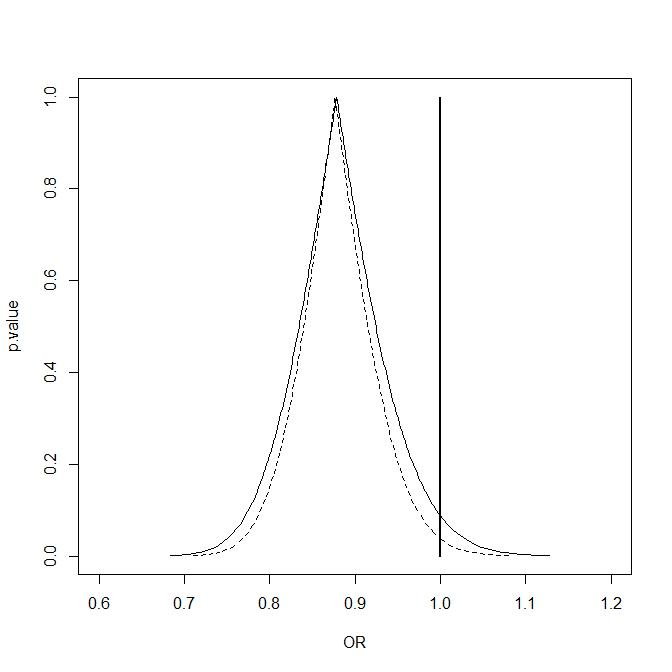

In [1]:
using Distributions
using StatsPlots

In [2]:
function ORMH(TBL; conf_level = 0.95)
    TT = sum.(eachrow(TBL))
    GG = @. TBL[:,1] * TBL[:,4] / TT
    HH = @. TBL[:,2] * TBL[:,3] / TT
    OR = sum(GG) / sum(HH)
    PP = @. (TBL[:,1] + TBL[:,4]) / TT
    QQ = @. (TBL[:,2] + TBL[:,3]) / TT
    VARlnOR = sum(@. GG*PP)/(2sum(GG)^2) + sum(@. GG*QQ+HH*PP)/(2sum(GG)*sum(HH)) + sum(@. HH*QQ)/(2sum(HH)^2)
    SElnOR = √VARlnOR # \sqrt TAB → √
    ORL = exp(log(OR) - quantile(Normal(), 1 - (1 - conf_level)/2)*SElnOR)
    ORU = exp(log(OR) + quantile(Normal(), 1 - (1 - conf_level)/2)*SElnOR)
    (estimate = OR, conf_int = (ORL, ORU), conf_level = conf_level)
end

ORMH (generic function with 1 method)

In [3]:
TBL = reshape(1:40, 10, 4) |> Matrix
TT = sum.(eachrow(TBL))
GG = @. TBL[:,1] * TBL[:,4] / TT
HH = @. TBL[:,2] * TBL[:,3] / TT
OR = sum(GG) / sum(HH)
PP = @. (TBL[:,1] + TBL[:,4]) / TT
QQ = @. (TBL[:,2] + TBL[:,3]) / TT
VARlnOR = sum(@. GG*PP)/(2sum(GG)^2) + sum(@. GG*QQ+HH*PP)/(2sum(GG)*sum(HH)) + sum(@. HH*QQ)/(2sum(HH)^2)

0.0318893956578057

In [4]:
TenStudies = [
    215 229 311-215 306-229
     38  33  59-38   51-33
    161 174 293-161 293-174
     76  88 164-76  163-88
    103 105 129-103 133-105
     65  67 120-65  125-67
     81  75 113-81  110-75
     48  63 160-48  159-63
     22  21  60-22  62-21
     56  51 137-56  140-51
]

10×4 Matrix{Int64}:
 215  229   96   77
  38   33   21   18
 161  174  132  119
  76   88   88   75
 103  105   26   28
  65   67   55   58
  81   75   32   35
  48   63  112   96
  22   21   38   41
  56   51   81   89

In [5]:
ElevenStudies = [
    TenStudies
    468 480 229 205
]

11×4 Matrix{Int64}:
 215  229   96   77
  38   33   21   18
 161  174  132  119
  76   88   88   75
 103  105   26   28
  65   67   55   58
  81   75   32   35
  48   63  112   96
  22   21   38   41
  56   51   81   89
 468  480  229  205

In [6]:
ORMH(TenStudies)

(estimate = 0.8781804164991955, conf_int = (0.7565860364363417, 1.0193167819422062), conf_level = 0.95)

In [7]:
ORMH(ElevenStudies)

(estimate = 0.8765652832028286, conf_int = (0.7738329501187079, 0.9929361312394176), conf_level = 0.95)

In [8]:
function pvpORMH!(XTAB; xlim = (0.6, 1.2), kwargs...)
    cp = [(1:9)./1000; (1:9)./100; (10:90)./100; 0.9 .+ (1:9)./100; 0.99 .+ (1:9)./1000]
    cl = 1 .- cp
    lu = zeros(length(cl))
    uu = zeros(length(cl))
    for i in 1:length(cl)
        res = ORMH(XTAB; conf_level = cl[i])
        lu[i] = res.conf_int[1]
        uu[i] = res.conf_int[2]
    end
    cpx = [cp; 1; reverse(cp)]
    cOR = [lu; ORMH(XTAB).estimate; reverse(uu)]
    plot!(cOR, cpx; xlim, kwargs...)
end

pvpORMH! (generic function with 1 method)

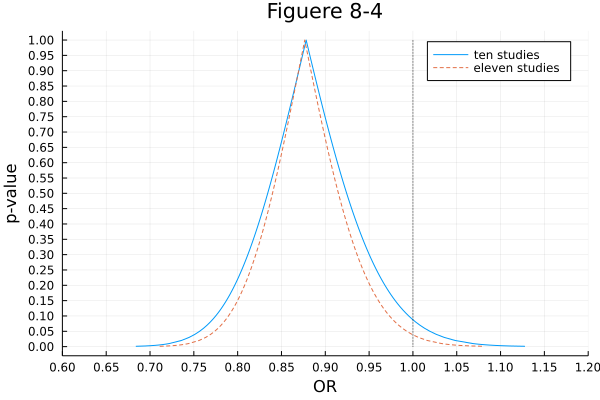

In [9]:
plot(; title="Figuere 8-4")
pvpORMH!(TenStudies; label="ten studies")
pvpORMH!(ElevenStudies; label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, ls=:dot)
plot!(; xtick = 0.6:0.05:1.2, ytick = 0:0.05:1)
plot!(; xlabel="OR", ylabel="p-value")

以上では「信頼区間を大量に計算することによってP値函数をプロットする」という実装になっているが, 以下ではP値函数を直接定義することによって同一のグラフをプロットしてみる.

In [10]:
function logOR_and_SE_normalapprox(TBL)
    TT = sum.(eachrow(TBL))
    GG = @. TBL[:,1] * TBL[:,4] / TT
    HH = @. TBL[:,2] * TBL[:,3] / TT
    OR = sum(GG) / sum(HH)
    PP = @. (TBL[:,1] + TBL[:,4]) / TT
    QQ = @. (TBL[:,2] + TBL[:,3]) / TT
    VARlnOR = sum(@. GG*PP)/(2sum(GG)^2) + sum(@. GG*QQ+HH*PP)/(2sum(GG)*sum(HH)) + sum(@. HH*QQ)/(2sum(HH)^2)
    SElnOR = √VARlnOR # \sqrt TAB → √
    (logOR = log(OR), SE = SElnOR)
end

function pval_ORMH_normalapprox(TBL, or)
    (; logOR, SE) = logOR_and_SE_normalapprox(TBL)
    normal = Normal(logOR, SE)
    min(1, 2cdf(normal, log(or)), 2ccdf(normal, log(or)))
end

pval_ORMH_normalapprox (generic function with 1 method)

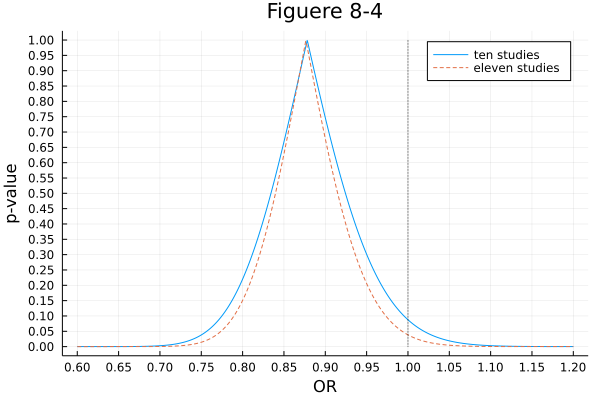

In [11]:
or = range(0.6, 1.2, 1000)
plot(; title="Figuere 8-4")
plot!(or, or -> pval_ORMH_normalapprox(TenStudies, or); label="ten studies")
plot!(or, or -> pval_ORMH_normalapprox(ElevenStudies, or); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, ls=:dot)
plot!(; xtick = range(extrema(or)...; step=0.05), ytick = 0:0.05:1)
plot!(; xlabel="OR", ylabel="p-value")

__比較:__ 以下のように2つの方法によるプロットはぴったり一致している.

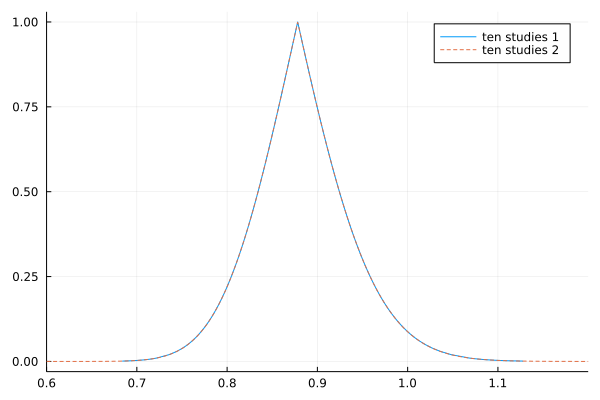

In [12]:
plot()
pvpORMH!(TenStudies; label="ten studies 1")
plot!(or, or -> pval_ORMH_normalapprox(TenStudies, or); label="ten studies 2", ls=:dash)

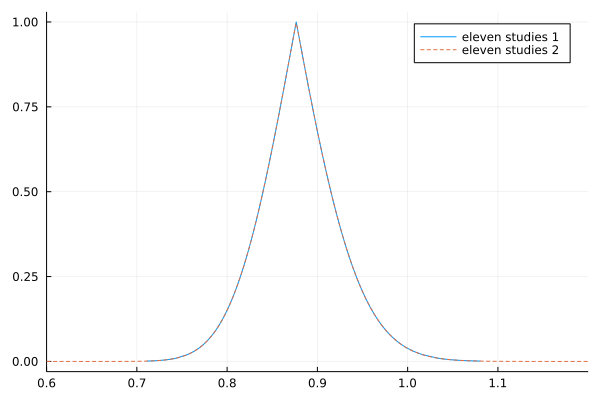

In [13]:
plot()
pvpORMH!(ElevenStudies; label="eleven studies 1")
plot!(or, or -> pval_ORMH_normalapprox(ElevenStudies, or); label="eleven studies 2", ls=:dash)